# Project Assignment

**1)** Description of the project.

**2a)** Description of the nonlinear system with its mathematical model.

**2b)** Definition of states, control inputs, and considered disturbances.

**3a)** Selection of the operating point(s) and linearization of the system.

**3b)** Verification of the controllability of the linearized model.

**4)** Design of an infinite-horizon LQR controller for system stabilization.

**5)** Either (a) formulation of the MPC stabilization problem with input/state constraints or (b) design of a finite-horizon LQR controller for trajectory planning.

**6)** Simulation of nonlinear system control (a) without and (b) with disturbances.

**7)** Conclusion.

# Imports

In [1]:
import importlib
import math
import typing as T
from collections import namedtuple
from pprint import pprint

import control
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import sympy as smp
from IPython.display import HTML, Image, Latex, display

import helpers

importlib.reload(helpers)
from helpers import GRAVITY, HALF, discretization_by_rk4_integration, plot, print2, print_array, rk4

# 1) System Description

Pendulum (pole) on a cart which can move in horizontal and vertical direction. Both cart and pendulum are simplified to point masses. The cart is controlled with horizontal and vertical force.

**Inputs**: horizontal force $f_x$ and vertical force $f_y$.

**Disturbances**: horizontal force offset $\Delta f_x$.

**States**: cart's position $x_c$, $y_c$, pendulum's rotation $\alpha$ and their speeds $v_{xc} = \dot{x}_c$, $v_{yc} = \dot{y}_c$, $\omega = \dot{\alpha}$.

**Outputs**: all state variables.

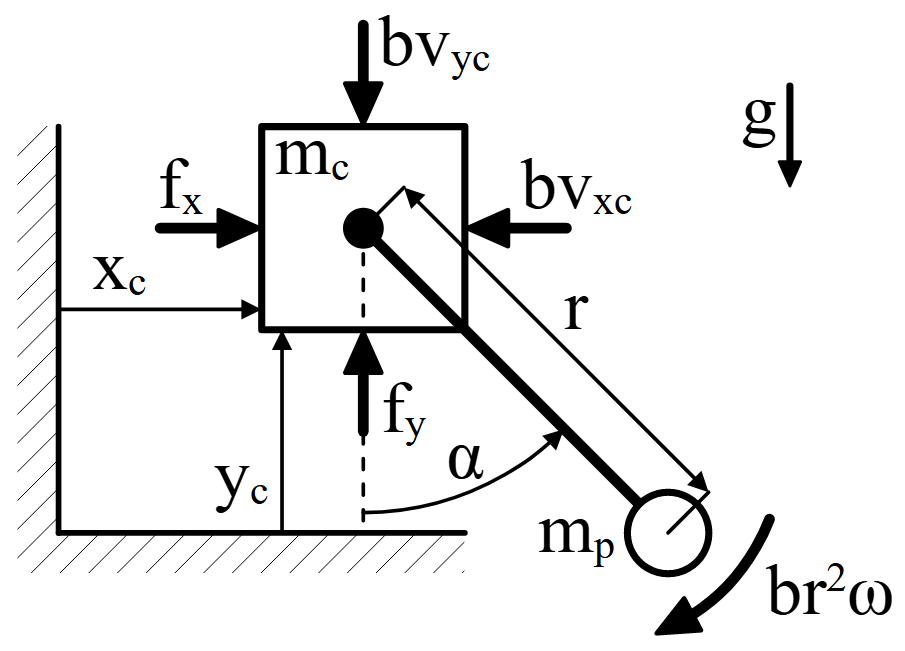

In [2]:
Image(filename="diagram.png", width=500)

# 2) Dynamics Derivation

## Symbolic Variables

In [3]:
t, g, m_c, m_p, r, b = smp.symbols("t g m_c m_p r b", real=True, positive=True)
print2("constants", t, g, m_c, m_p, r, b)

constants = {
    g: GRAVITY,  # m/s^2
    m_c: smp.Rational("0.5"),  # kg
    m_p: smp.Rational("0.2"),  # kg
    r: smp.Rational("0.4"),  # m
    b: smp.Rational("0.1"),  # N/m/s
}

x_c, y_c, alpha = (f(t) for f in smp.symbols("x_c y_c alpha", real=True, cls=smp.Function))
print2("generalized (independent) coordinates", x_c, y_c, alpha)

x_p = x_c + r * smp.sin(alpha)
y_p = y_c - r * smp.cos(alpha)
print2("dependent coordinates", x_p, y_p)

f_x, f_y = smp.symbols("f_x f_y", real=True)
print2("control forces", f_x, f_y)

dx_c, dy_c, dx_p, dy_p, dalpha = (smp.diff(f, t) for f in (x_c, y_c, x_p, y_p, alpha))
print2("velocities", dx_c, dy_c, dx_p, dy_p, dalpha)

ddx_c, ddy_c, ddalpha = (smp.diff(f, t) for f in (dx_c, dy_c, dalpha))
print2("accelerations", ddx_c, ddy_c, ddalpha)

ssx = smp.symbols("x1 x2 x3 x4 x5 x6", real=True)
ssu = smp.symbols("u1 u2", real=True)
print2("state variables", *ssx)
print2("control inputs", *ssu)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Energy and Forces

In [4]:
Ek = HALF * m_c * (dx_c**2 + dy_c**2) + HALF * m_p * (dx_p**2 + dy_p**2)  # type: ignore
print2("kinetic energy", Ek)

Ep = m_c * g * y_c + m_p * g * y_p
print2("potential energy", Ep)

Q_x_c = f_x - b * dx_c
Q_y_c = f_y - b * dy_c
Q_alpha = -b * r**2 * dalpha  # b_rot = b * r**2
print2("generalized forces", Q_x_c, Q_y_c, Q_alpha)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Langrange Equations

In [5]:
L = Ek - Ep
eom_x_c = smp.Eq(smp.diff(smp.diff(L, dx_c), t) - smp.diff(L, x_c), Q_x_c)  # type: ignore
eom_y_c = smp.Eq(smp.diff(smp.diff(L, dy_c), t) - smp.diff(L, y_c), Q_y_c)  # type: ignore
eom_alpha = smp.Eq(smp.diff(smp.diff(L, dalpha), t) - smp.diff(L, alpha), Q_alpha)  # type: ignore
print2("lagrange equations", eom_x_c, eom_y_c, eom_alpha, newline=True)

<IPython.core.display.Latex object>

## Nonlinear Equations of Motion

In [6]:
_ = smp.solve(
    (eom_x_c, eom_y_c, eom_alpha),
    (ddx_c, ddy_c, ddalpha),
)
eom = smp.Matrix(
    [
        [smp.simplify(_[ddx_c])],
        [smp.simplify(_[ddy_c])],
        [smp.simplify(_[ddalpha])],
    ]
)
print2("equations of motion", eom, newline=True)

<IPython.core.display.Latex object>

## Nonlinear State-Space Representation

In [7]:
ss_eom = smp.Matrix(
    [
        [dx_c],
        [dy_c],
        [dalpha],
        [eom[0, 0]],
        [eom[1, 0]],
        [eom[2, 0]],
    ]
)
ss_subs = {
    x_c: ssx[0],
    y_c: ssx[1],
    alpha: ssx[2],
    dx_c: ssx[3],
    dy_c: ssx[4],
    dalpha: ssx[5],
    f_x: ssu[0],
    f_y: ssu[1],
}
ss_subs_reversed = {key: ss_subs[key] for key in reversed(ss_subs)}
ss_eom = ss_eom.subs(ss_subs_reversed)
print2("state-space representation", ss_eom, newline=True)

<IPython.core.display.Latex object>

In [8]:
ss_eom_num = ss_eom.subs(constants)
print2("state-space representation", ss_eom_num, newline=True)

<IPython.core.display.Latex object>

## Equilibrium Analysis

In [9]:
u0_sym = smp.Matrix([[0], [g * (m_c + m_p)]])
u0_num = u0_sym.subs(constants)
print2("inputs", u0_sym, u0_num)

u0 = np.array(u0_num, dtype=np.float64)[:, 0]
print_array(u0)

<IPython.core.display.Latex object>

[0.    6.867]


In [10]:
_ = ss_eom.subs(
    {
        ssx[0]: 0,  # x_c
        ssx[1]: 0,  # y_c
        # ssx[2]: 0, # alpha
        ssx[3]: 0,  # dx_c
        ssx[4]: 0,  # dy_c
        ssx[5]: 0,  # dalpha
        ssu[0]: u0_sym[0, 0],  # f_x
        ssu[1]: u0_sym[1, 0],  # f_y
    }
)
_ = smp.simplify(_)  # compacts trig functions
print2(_)

<IPython.core.display.Latex object>

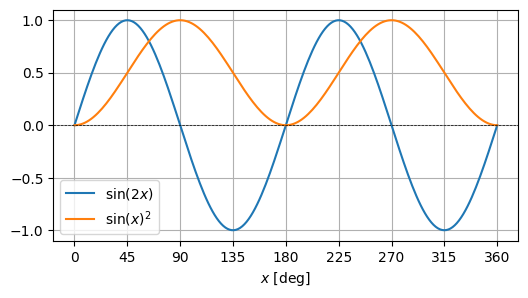

In [11]:
plt.figure(figsize=(6, 3))
_ = np.linspace(0, 2 * np.pi, 200)
plt.plot(np.rad2deg(_), np.sin(2 * _), label=r"$\sin(2x)$")
plt.plot(np.rad2deg(_), np.sin(_) ** 2, label=r"$\sin(x)^2$")
plt.axhline(0, color="black", lw=0.5, ls="--")
plt.xlabel(r"$x$ [deg]")
plt.xticks(np.arange(0, 361, 45))
plt.grid()
plt.legend()
plt.show()

## Callable Function

In [12]:
_non_lin_dynamics = smp.lambdify(list(ss_subs.values()), ss_eom_num, modules="numpy")
print(_non_lin_dynamics.__doc__)


def non_lin_dynamics(
    x: npt.NDArray[np.float64],
    u: npt.NDArray[np.float64],
    t: float,
) -> npt.NDArray[np.float64]:
    return _non_lin_dynamics(*x, *u)[:, 0]


print_array(
    non_lin_dynamics(
        np.array([0, 0, math.radians(0), 0, 0, math.radians(0)]),
        np.array([0, 0]),
        0,
    )
)

Created with lambdify. Signature:

func(x1, x2, x3, x4, x5, x6, u1, u2)

Expression:

Matrix([[x4], [x5], [x6], [2*u1*cos(2*x3)/7 + 12*u1/7 + 2*u2*sin(2*x3)/7 -...

Source code:

def _lambdifygenerated(x1, x2, x3, x4, x5, x6, u1, u2):
    return array([[x4], [x5], [x6], [(2/7)*u1*cos(2*x3) + (12/7)*u1 + (2/7)*u2*sin(2*x3) - 1/35*x4*cos(2*x3) - 6/35*x4 - 1/35*x5*sin(2*x3) + (4/35)*x6**2*sin(x3) + (2/25)*x6*cos(x3)], [(2/7)*u1*sin(2*x3) - 2/7*u2*cos(2*x3) + (12/7)*u2 - 1/35*x4*sin(2*x3) + (1/35)*x5*cos(2*x3) - 6/35*x5 - 4/35*x6**2*cos(x3) + (2/25)*x6*sin(x3) - 981/100], [-5*u1*cos(x3) - 5*u2*sin(x3) + (1/2)*x4*cos(x3) + (1/2)*x5*sin(x3) - 7/10*x6]])


Imported modules:


[ 0.    0.    0.    0.   -9.81  0.  ]
